## Energy Dataset

The following script aims to apply different models for forecasting future values in time series.

The time series under analysis is the energy consumption in a region of Brazil, with data available from 1979 to the year 2020.

The models will use data up to 2016 for training, while the remaining data will be used to test the predictions made.

The tested models will include Exponential Smoothing (Simple, Holt, Holt-Winters) and the optimized ARIMA model.


### Checking Dataset

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import warnings

warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Checking Dataset
df_energy = pd.read_csv(f"Data/consumo_energia.csv", index_col=0)
df_energy.head(10)

,Data,Consumo
0,1979.01,5623
1,1979.02,5551
2,1979.03,5725
3,1979.04,5797
4,1979.05,6002
5,1979.06,5988
6,1979.07,6054
7,1979.08,6022
8,1979.09,6353
9,1979.10,6144


In [3]:
# Transforming the Date column with string operations
df_energy['Data'] = df_energy['Data'].astype(str).str.replace('.', '-')
df_energy['Data'].head(12)

0     1979-01
1     1979-02
2     1979-03
3     1979-04
4     1979-05
5     1979-06
6     1979-07
7     1979-08
8     1979-09
9      1979-1
10    1979-11
11    1979-12
Name: Data, dtype: object

In [4]:
# Transforming the Date column with string operations
df_energy['Data'].loc[df_energy['Data'].str.endswith('-1')] = df_energy['Data'].loc[df_energy['Data'].str.endswith('-1')].str.replace('-1', '-10')
df_energy['Data'].head(12)

0     1979-01
1     1979-02
2     1979-03
3     1979-04
4     1979-05
5     1979-06
6     1979-07
7     1979-08
8     1979-09
9     1979-10
10    1979-11
11    1979-12
Name: Data, dtype: object

In [5]:
# Transforming the Date column type
df_energy['Data'] = pd.to_datetime(df_energy['Data'] + '-01')

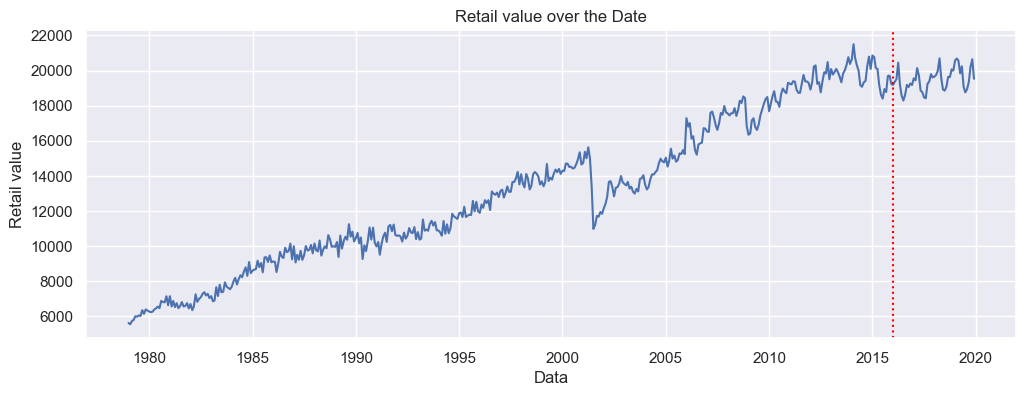

In [6]:
# Plotting the Retail Value over the Date
plt.figure(figsize=(12,4))
plt.plot(df_energy['Data'], df_energy['Consumo'])
plt.xlabel('Data')
plt.ylabel('Retail value')
plt.title('Retail value over the Date')
plt.axvline(dt.datetime(2016, 1, 1), color='red', linestyle='dotted')
plt.show();

In [7]:
# Decomposing the time series
decomposed_ts = sm.tsa.seasonal_decompose(df_energy['Consumo'], period=12)

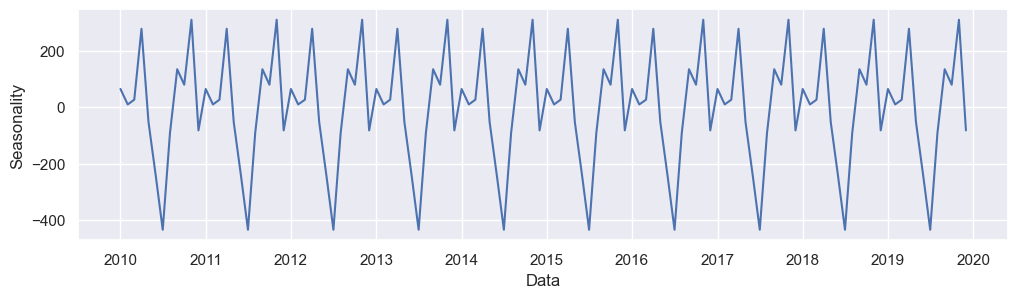

In [8]:
# Plotting the Seasonality
plt.figure(figsize=(12,3))
plt.plot(df_energy['Data'][len(df_energy)-120:], decomposed_ts.seasonal[len(df_energy)-120:])
plt.xlabel('Data')
plt.ylabel('Seasonality')
plt.show();

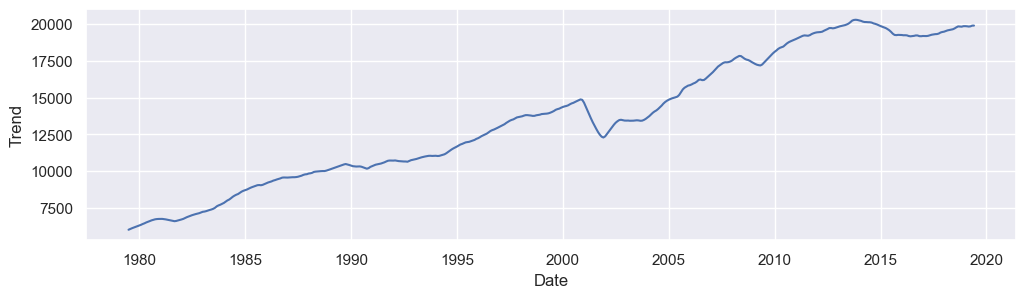

In [9]:
# Plotting the Trend
plt.figure(figsize=(12,3))
plt.plot(df_energy['Data'], decomposed_ts.trend)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.show();



### Creating and Adjusting Exponential Smoothing Models


From the charts, it is quite clear to observe the annual seasonal behavior, in addition to the upward trend. So the Holt-Winters model will probably get the best predictions.

In [10]:
# Splitting the dataset on train and test
split_index = df_energy.loc[df_energy['Data']==dt.datetime(2016,1,1)].index[0]
df_train = df_energy['Consumo'].loc[:split_index]
df_test = df_energy['Consumo'].loc[split_index+1:]

In [11]:
# SES Model
model_ses = sm.tsa.SimpleExpSmoothing(df_train, initialization_method='estimated')
model_ses = model_ses.fit()
model_ses.summary()

Dep. Variable:,Consumo,No. Observations:,445
Model:,SimpleExpSmoothing,SSE,89063186.122
Optimized:,True,AIC,5436.018
Trend:,None,BIC,5444.214
Seasonal:,None,AICC,5436.109
Seasonal Periods:,None,Date:,"Thu, 18 May 2023"
Box-Cox:,False,Time:,18:26:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7290522,alpha,True
initial_level,5618.9227,l.0,True


In [12]:
# Holt Linear Model
model_holt = Holt(df_train, damped_trend=False, initialization_method='estimated')
model_holt = model_holt.fit()
model_holt.summary()

Dep. Variable:,Consumo,No. Observations:,445
Model:,Holt,SSE,89885478.917
Optimized:,True,AIC,5444.108
Trend:,Additive,BIC,5460.500
Seasonal:,None,AICC,5444.300
Seasonal Periods:,None,Date:,"Thu, 18 May 2023"
Box-Cox:,False,Time:,18:26:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7121429,alpha,True
smoothing_trend,0.0197817,beta,True


In [13]:
# Model Holt Winter (Additive)
model_hw_add = ExponentialSmoothing(df_train, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
model_hw_add = model_hw_add.fit()
model_hw_add.summary()

Dep. Variable:,Consumo,No. Observations:,445
Model:,ExponentialSmoothing,SSE,72258749.956
Optimized:,True,AIC,5370.972
Trend:,Additive,BIC,5436.541
Seasonal:,Additive,AICC,5372.578
Seasonal Periods:,12,Date:,"Thu, 18 May 2023"
Box-Cox:,False,Time:,18:26:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7124307,alpha,True
smoothing_trend,9.9965e-05,beta,True


In [14]:
# Model Holt Winter (Multiplicative)
model_hw_mul = ExponentialSmoothing(df_train, trend='mul', seasonal='mul', seasonal_periods=12, initialization_method='heuristic')
model_hw_mul = model_hw_mul.fit()
model_hw_mul.summary()

Dep. Variable:,Consumo,No. Observations:,445
Model:,ExponentialSmoothing,SSE,77369077.298
Optimized:,True,AIC,5401.380
Trend:,Multiplicative,BIC,5466.950
Seasonal:,Multiplicative,AICC,5402.986
Seasonal Periods:,12,Date:,"Thu, 18 May 2023"
Box-Cox:,False,Time:,18:26:20
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6414286,alpha,True
smoothing_trend,0.0278882,beta,True


### Creating and Adjusting ARIMA Model

In [15]:
# Dickey Fuller Test
adf_result = adfuller(df_energy['Consumo'], maxlag=1)
adf_result

(-1.3015458142577163,
 0.6284648053601171,
 1,
 490,
 {'1%': -3.4437660979098843,
  '5%': -2.8674565460819896,
  '10%': -2.569921291128696},
 7400.58529251654)

In [16]:
# The series is not stationary
# It needs to be differenced
diffs = ndiffs(df_energy['Consumo'], test='adf')
diffs

1

In [17]:
# Differencing
dif_df_train = np.diff(df_energy['Consumo'].loc[df_train.index])

In [18]:
# Creating the ARIMA model
arima_model = auto_arima(dif_df_train, trace=True, seazonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6714.076, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6620.929, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6631.483, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6714.006, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6683.796, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6621.061, Time=1.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6594.508, Time=0.60 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6631.078, Time=0.24 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6627.362, Time=0.56 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=6627.684, Time=0.40 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : 

In [19]:
# Fitting
arima_model.fit(dif_df_train)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [20]:
# Model Outputs
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  444
Model:             SARIMAX(1, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -3286.678
Date:                                 Thu, 18 May 2023   AIC                           6585.355
Time:                                         18:26:48   BIC                           6609.930
Sample:                                              0   HQIC                          6595.046
                                                 - 444                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2653      0.039     -6.797      0.000      -0.342      -0.189
ar.S.L12       0.6731      0.241      2.792      0.005       0.201       1.146
ar.S.L24       0.2942      0.237      1.240      0.215      -0.171       0.759
ma.S.L12      -0.4156      0.229     -1.812      0.070      -0.865       0.034
ma.S.L24      -0.4053      0.203     -2.001      0.045      -0.802      -0.008
sigma2      1.517e+05   6950.239     21.830      0.000    1.38e+05    1.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               956.11
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Checking Predictions and the Model's MAPE

In [21]:
# Creating a function to calculate the MAPE
def mape(serie):
    print(np.mean(abs((df_test-serie)/df_test))*100)
    return

In [22]:
# Getting SES predictions
ses_predictions = model_ses.forecast(steps=len(df_test))
# Getting HOLT predictions
holt_predictions = model_holt.forecast(steps=len(df_test))
# Getting HW Add predictions
hw_add_predictions = model_hw_add.forecast(steps=len(df_test))
# Getting HW Multiplicative predictions
hw_mul_predictions = model_hw_mul.forecast(steps=len(df_test))

In [23]:
# SES MAPE
mape(ses_predictions)

2.790481154707416


In [24]:
# Holt Linear MAPE
mape(holt_predictions)

2.502721742667035


In [25]:
# Holt-Winters (additive) MAPE
mape(hw_add_predictions)

2.784080238958958


In [26]:
# Holt-Winters (multiplicative) MAPE
mape(hw_mul_predictions)

3.4988268863908782


In [27]:
# Getting Arima predictions
arima_predictions_dif = arima_model.predict(n_periods=len(df_test))

The ARIMA predictions are based on the differenced values, used for fitting the model. These values needs to pass for the reverse process.

In [28]:
# Getting the train database last value
train_last_value = df_energy['Consumo'].loc[split_index]
# Getting the reversed predictions
arima_predictions = np.r_[train_last_value, arima_predictions_dif].cumsum()[1:]

In [29]:
# ARIMA MAPE
mape(arima_predictions)

1.8619192814330838


The MAPE of the ARIMA model was the lowest, indicating that this model performed the best in predicting new values. The second-best model was Holt-Linear, while additive HW and SES had practically the same values. On the other hand, multiplicative HW performed the worst in predictions.

The predicted values will be plotted along with the actual values in the graph below.

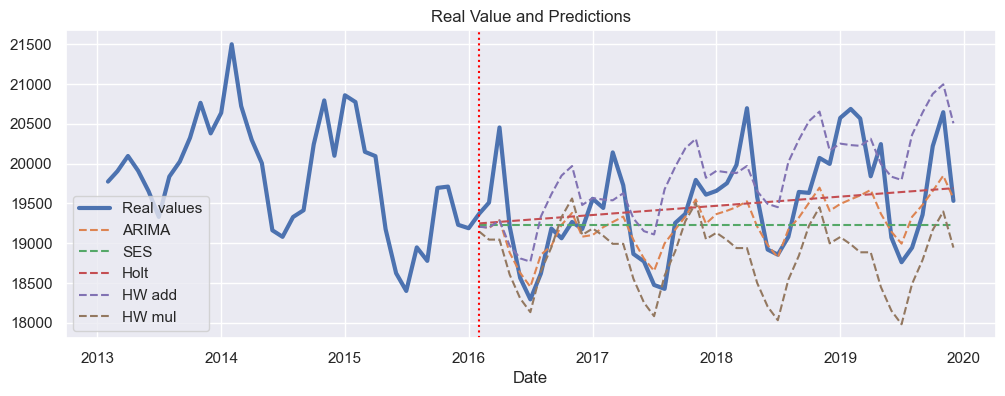

In [30]:
# Plotting the Retail Value and predictions after 2020
plt.figure(figsize=(12,4))
plt.plot(df_energy['Data'].loc[df_energy['Data']>dt.datetime(2013, 1, 1)], df_energy['Consumo'].loc[df_energy['Data']>dt.datetime(2013, 1, 1)], lw=3)
plt.plot(df_energy['Data'].loc[df_test.index], arima_predictions, linestyle='dashed')
plt.plot(df_energy['Data'].loc[df_test.index], ses_predictions, linestyle='dashed')
plt.plot(df_energy['Data'].loc[df_test.index], holt_predictions, linestyle='dashed')
plt.plot(df_energy['Data'].loc[df_test.index], hw_add_predictions, linestyle='dashed')
plt.plot(df_energy['Data'].loc[df_test.index], hw_mul_predictions, linestyle='dashed')
plt.legend(['Real values', 'ARIMA', 'SES', 'Holt', 'HW add', 'HW mul'])
plt.xlabel('Date')
plt.title('Real Value and Predictions')
plt.axvline(dt.datetime(2016, 2, 1), color='red', linestyle='dotted')
plt.show();